In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/pbl555/dataset8_cuong.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_path = "/content/dataset/dataset8_cuong/train"
val_path = "/content/dataset/dataset8_cuong/validation"
test_path = "/content/dataset/dataset8_cuong/test"

In [ ]:
data_train = tf.keras.utils.image_dataset_from_directory(train_path, image_size=(224, 224), validation_split=False, batch_size=64, shuffle=True)

Found 9636 files belonging to 8 classes.


In [ ]:
data_cat = data_train.class_names
data_cat

['correct',
 'head_down',
 'head_left',
 'head_right',
 'leaning_left',
 'leaning_right',
 'left_hand_up',
 'right_hand_up']

In [ ]:
data_val = tf.keras.utils.image_dataset_from_directory(val_path, image_size=(224, 224), validation_split=False, batch_size=32, shuffle=True)
data_val.class_names

Found 3193 files belonging to 8 classes.


['correct',
 'head_down',
 'head_left',
 'head_right',
 'leaning_left',
 'leaning_right',
 'left_hand_up',
 'right_hand_up']

In [ ]:
data_test = tf.keras.utils.image_dataset_from_directory(test_path, image_size=(224, 224), validation_split=False, batch_size=32, shuffle=True)

In [ ]:
# Scale data
def scale_data(image, label):
    # Convert image to float32
    image = tf.cast(image, tf.float32)
    # Scale image using Min-Max Scaling
    image = image / 255.0
    return image, label

# Apply scaling to datasets
scaled_data_train = data_train.map(scale_data)
scaled_data_val = data_val.map(scale_data)
scaled_data_test = data_test.map(scale_data)

NameError: name 'data_test' is not defined

tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


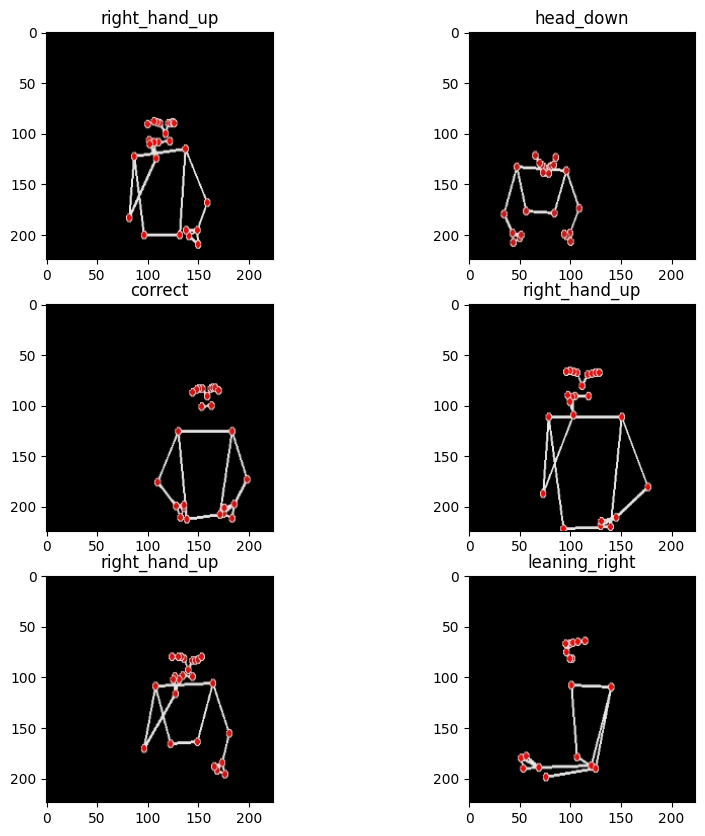

In [ ]:
plt.figure(figsize=(10, 10))
for image, labels in data_train.take(1):
  for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(data_cat[labels[i]])
    print(labels[i])

In [ ]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
import tensorflow as tf

# Tạo một mô hình VGG19 đã được huấn luyện trước, không bao gồm các lớp fully connected layer ở cuối
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

model = Sequential()
# Add the pre-processing layer to the model
# model.add(tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input))

model.add(base_model)
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3e-3)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))  # Output layer, ví dụ binary classification

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, 224, 224, 3))

# In summary của mô hình
model.summary()



9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 32)                2007072   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 4265320 (16.27 MB)
Trainable params: 2007336 

In [ ]:
from keras.callbacks import EarlyStopping
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(scaled_data_train, validation_data=scaled_data_val, epochs=100, callbacks=[early_stopping])

Epoch 1/100
151/151 [==============================] - 43s 203ms/step - loss: 1.6413 - accuracy: 0.4759 - val_loss: 1.0736 - val_accuracy: 0.7253
Epoch 2/100
151/151 [==============================] - 20s 129ms/step - loss: 0.7651 - accuracy: 0.7848 - val_loss: 0.7606 - val_accuracy: 0.7958
Epoch 3/100
151/151 [==============================] - 25s 160ms/step - loss: 0.5483 - accuracy: 0.8595 - val_loss: 0.6180 - val_accuracy: 0.8152
Epoch 4/100
151/151 [==============================] - 21s 133ms/step - loss: 0.4533 - accuracy: 0.8835 - val_loss: 0.5684 - val_accuracy: 0.8494
Epoch 5/100
151/151 [==============================] - 19s 122ms/step - loss: 0.4012 - accuracy: 0.9012 - val_loss: 0.4916 - val_accuracy: 0.8801
Epoch 6/100
151/151 [==============================] - 19s 123ms/step - loss: 0.3417 - accuracy: 0.9235 - val_loss: 0.4244 - val_accuracy: 0.9129
Epoch 7/100
151/151 [==============================] - 20s 128ms/step - loss: 0.3139 - accuracy: 0.9312 - val_loss: 0.4115 -

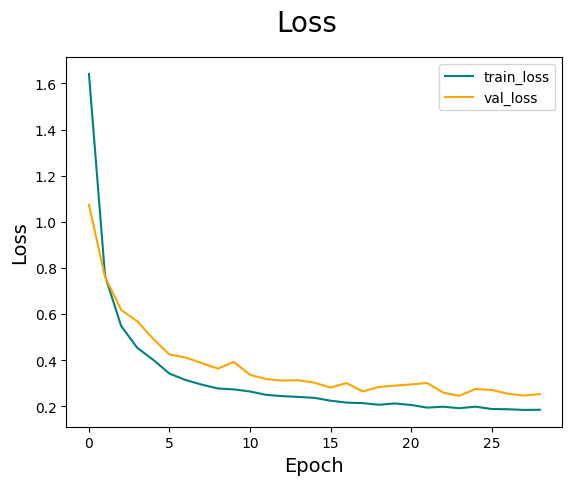

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='train_loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=14)  # Thêm nhãn cho cột x
plt.ylabel('Loss', fontsize=14)   # Thêm nhãn cho cột y
plt.legend(loc="upper right")
plt.show()

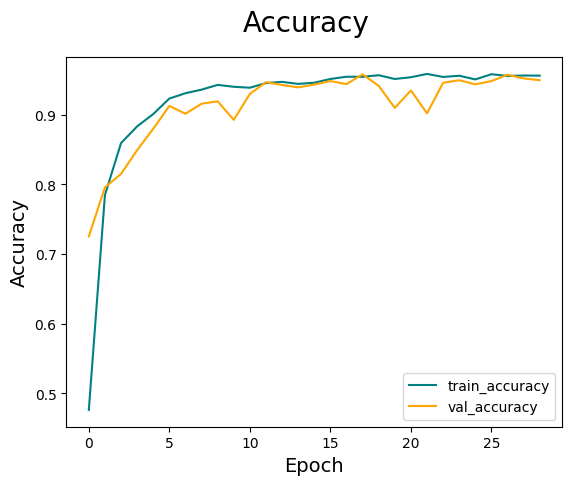

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='train_accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=14)  # Thêm nhãn cho cột x
plt.ylabel('Accuracy', fontsize=14)   # Thêm nhãn cho cột y
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.evaluate(scaled_data_test)

50/50 [==============================] - 2s 43ms/step - loss: 0.4545 - accuracy: 0.8600


[0.4545052647590637, 0.8600000143051147]

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test batches
for batch in scaled_data_test.as_numpy_iterator():
    X, y = batch
    # Perform prediction using the model
    yhat = model.predict(X)
    # Convert predicted probabilities to labels
    y_pred = np.argmax(yhat, axis=-1)
    # Append true labels and predicted labels
    true_labels.extend(y)
    predicted_labels.extend(y_pred)

# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the evaluation metrics
print(f'Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}')


1/1 [==============================] - 0s 32ms/step
Precision: 0.9066667049071413, Recall: 0.86, Accuracy: 0.86


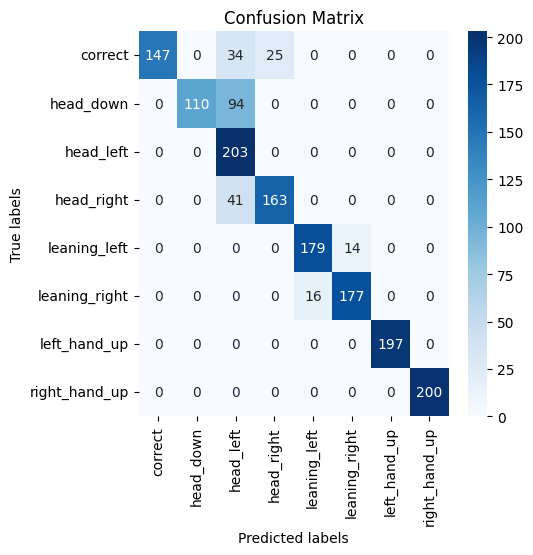

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tạo ma trận confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Tạo plot cho ma trận confusion
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_cat, yticklabels=data_cat)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.evaluate(scaled_data_val)

51/51 [==============================] - 2s 43ms/step - loss: 0.3749 - accuracy: 0.8993


[0.37489554286003113, 0.8993163704872131]

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test batches
for batch in scaled_data_val.as_numpy_iterator():
    X, y = batch
    # Perform prediction using the model
    yhat = model.predict(X)
    # Convert predicted probabilities to labels
    y_pred = np.argmax(yhat, axis=-1)
    # Append true labels and predicted labels
    true_labels.extend(y)
    predicted_labels.extend(y_pred)

# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the evaluation metrics
print(f'Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}')


1/1 [==============================] - 1s 769ms/step
Precision: 0.9069020706800229, Recall: 0.8993163455562461, Accuracy: 0.8993163455562461


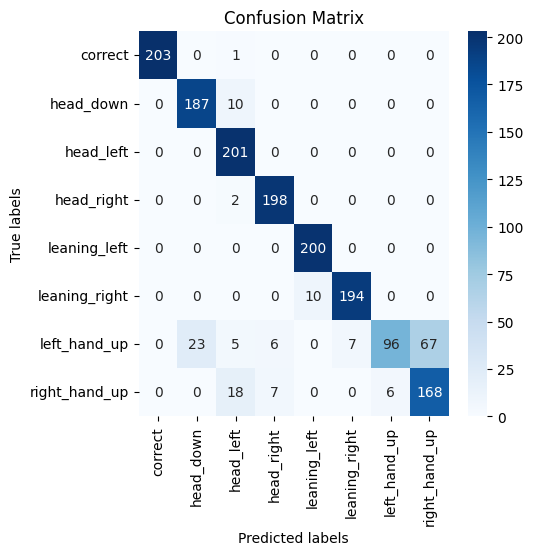

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tạo ma trận confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Tạo plot cho ma trận confusion
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_cat, yticklabels=data_cat)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/pbl555/mobilenet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
